In [1]:
import json
import joblib
from pprint import pprint
from pathlib import Path

import pandas as pd
import numpy as np
import polars as pl

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

import lightgbm as lgb
from lightgbm.callback import log_evaluation, early_stopping

from isic_helper import DotDict
from isic_helper import get_folds
from isic_helper import compute_auc, compute_pauc

pd.options.display.max_columns = 1000

In [2]:
cfg = DotDict()
cfg.seed = 2022

cfg.models_output_dir = "models"
cfg.model_name = "lgb_v4"

In [3]:
INPUT_PATH = Path("/kaggle/input/isic-2024-challenge/")
MODELS_OUTPUT_PATH = Path(f"{cfg.models_output_dir}")
MODELS_OUTPUT_PATH.mkdir(exist_ok=True)

id_column = "isic_id"
target_column = "target"
group_column = "patient_id"

In [4]:
def read_data(path, is_train=True):
    df = pl.read_csv(path, 
                     schema_overrides={"age_approx": pl.Float32}, 
                     null_values=["NA"])
    df = df.rename({"age_approx": "age"})
    if is_train:
        folds_df = pl.read_csv(path.parent.parent / "isic-scd-folds/folds.csv")
        df = df.join(folds_df, on=[id_column , group_column], how="left")
    return df

def feature_engineering(df):
    df = df.join(
        df.group_by(group_column).agg(pl.col("age").max().alias("age_approx")),
        on=group_column,
        how="left"
    ).drop("age")
    # Idea: 1
#     df = df.with_columns(
#         pl.concat_str(
#             [pl.col("sex"), pl.col("age_approx").cast(pl.Utf8).fill_null("NA")]
#         ).alias("sex_age_approx")
#     )
    # Idea: 2
#     df = df.with_columns(
#         lesion_size_ratio = pl.col('tbp_lv_minorAxisMM') / pl.col('clin_size_long_diam_mm'),
#     ).with_columns(
#         ((pl.col("lesion_size_ratio") - pl.col("lesion_size_ratio").mean().over(group_column)) / (pl.col("lesion_size_ratio").std().over(group_column) + 1e-5)).alias("lesion_size_ratio_norm")
#     ).drop("lesion_size_ratio")
    # Idea: 3
    df = df.with_columns(
        hue_contrast=(pl.col("tbp_lv_H") - pl.col("tbp_lv_Hext")).abs()
    )
    return df.to_pandas()

def get_encoder_and_fit(df, num_cols, ord_cat_cols, ohe_cat_cols):
    mixed_encoded_preprocessor = ColumnTransformer(
    [
        ("numerical", "passthrough", num_cols),
        (
            "ord_categorical",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-2, encoded_missing_value=-1, dtype=int),
            ord_cat_cols,
        ),
        (
            "ohe_categorical",
            OneHotEncoder(sparse_output=False, dtype=np.int32, handle_unknown="ignore"),
            ohe_cat_cols
        )
    ],
    verbose_feature_names_out=False,

    )
    mixed_encoded_preprocessor.set_output(transform="pandas")
    
    mixed_encoded_preprocessor.fit(df)
    return mixed_encoded_preprocessor
    

In [5]:
train = read_data(INPUT_PATH / "train-metadata.csv")
test = read_data(INPUT_PATH / "test-metadata.csv", is_train=False)

In [6]:
train = feature_engineering(train)
test = feature_engineering(test)

In [7]:
numerical_features = [
    "age_approx", 
    "clin_size_long_diam_mm",
    "tbp_lv_A", "tbp_lv_Aext",
    "tbp_lv_B", "tbp_lv_Bext",
    "tbp_lv_C", "tbp_lv_Cext",
    "tbp_lv_H", "tbp_lv_Hext",
    "tbp_lv_L", "tbp_lv_Lext",
    "tbp_lv_areaMM2",
    "tbp_lv_area_perim_ratio",
    "tbp_lv_color_std_mean",
    "tbp_lv_deltaA", "tbp_lv_deltaB", "tbp_lv_deltaL", "tbp_lv_deltaLB", "tbp_lv_deltaLBnorm",
    "tbp_lv_eccentricity",
    "tbp_lv_minorAxisMM",
    "tbp_lv_nevi_confidence",
    "tbp_lv_norm_border", "tbp_lv_norm_color",
    "tbp_lv_perimeterMM",
    "tbp_lv_radial_color_std_max",
    "tbp_lv_stdL", "tbp_lv_stdLExt",
    "tbp_lv_symm_2axis", "tbp_lv_symm_2axis_angle",
    "tbp_lv_x", "tbp_lv_y", "tbp_lv_z",
]

ord_categorical_features = [
    "sex", 
    "anatom_site_general", 
    "tbp_tile_type", 
    "tbp_lv_location", 
    "tbp_lv_location_simple",
    "attribution", 
    "copyright_license"
]

numerical_features += [
#     "lesion_size_ratio_norm",
#     "lesion_3d_distance"
    "hue_contrast"
]

ord_categorical_features += [
#     "sex_age_approx"
]

In [8]:
encoder = get_encoder_and_fit(train, numerical_features, ord_categorical_features, [])
with open(f"{cfg.model_name}_encoder.joblib", "wb") as f:
    joblib.dump(encoder, f)

In [9]:
categorical_features = ord_categorical_features + ["age_approx"]

In [10]:
X_train = encoder.transform(train)
X_test = encoder.transform(test)

train_ids = train[id_column]
y_train = train[target_column]
groups = train[group_column]
folds = train["fold"]

print(f"Total number of columns: {len(X_train.columns)}")

Total number of columns: 42


In [11]:
X_train.head()

,age_approx,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,tbp_lv_L,tbp_lv_Lext,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaA,tbp_lv_deltaB,tbp_lv_deltaL,tbp_lv_deltaLB,tbp_lv_deltaLBnorm,tbp_lv_eccentricity,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,hue_contrast,sex,anatom_site_general,tbp_tile_type,tbp_lv_location,tbp_lv_location_simple,attribution,copyright_license
0,60.0,3.04,20.244422,16.261975,26.922447,23.954773,33.684638,28.953117,53.058545,55.828924,54.367448,62.025701,3.152561,27.476170,0.00000,3.982447,2.967674,-7.658253,8.360566,5.784302,0.901302,1.543016,2.628592e-03,7.091360,0.000000,9.307003,0.00000,2.036195,2.637780,0.590476,85,-182.703552,613.493652,-42.427948,2.770379,2,3,1,12,4,4,1
1,60.0,1.10,31.712570,25.364740,26.331000,24.549290,41.219030,35.299260,39.702910,44.064040,48.861520,55.362360,0.919497,12.235290,0.00000,6.347830,1.781713,-6.500838,6.839008,4.987244,0.639885,0.821918,1.334303e-07,2.116402,0.000000,3.354148,0.00000,0.853227,3.912844,0.285714,55,-0.078308,1575.687000,57.174500,4.361130,2,2,1,0,0,4,1
2,60.0,3.40,22.575830,17.128170,37.970460,33.485410,44.174920,37.611800,59.265850,62.909730,53.961180,61.670520,3.265153,24.184620,0.00000,5.447655,4.485044,-7.709336,9.092376,6.290359,0.932147,1.194905,2.959177e-04,4.798335,0.000000,8.886309,0.00000,1.743651,1.950777,0.361905,105,123.649700,1472.010000,232.908900,3.643880,2,4,0,16,5,4,1
3,65.0,3.22,14.242329,12.164757,21.448144,21.121356,25.746200,24.374023,56.414429,60.060388,18.649518,23.314841,6.079940,14.889242,0.51452,2.077572,0.326788,-4.665323,4.783413,6.400196,0.654458,2.481328,2.198945e+01,1.975874,1.771705,9.514499,0.66469,1.258541,1.573733,0.209581,130,-141.024780,1442.185791,58.359802,3.645959,2,1,0,19,6,0,0
4,55.0,2.73,24.725520,20.057470,26.464900,25.710460,36.217980,32.608740,46.946070,52.041180,46.276310,54.855740,2.101708,19.902560,0.00000,4.668053,0.754434,-8.579431,9.148495,6.531302,0.946448,0.929916,1.378832e-03,3.658854,0.000000,6.467562,0.00000,2.085409,2.480509,0.313433,20,-72.315640,1488.720000,21.428960,5.095110,2,1,1,19,6,4,1


In [12]:
def pauc_80(preds, data):
    score_value = compute_pauc(data.get_label(), preds, min_tpr=0.8)   
    return "pauc_80", score_value, True


params = {
    "objective": "binary",
    "metric": "custom",
    "metric_freq": 10,
    "num_leaves": 63,
    "learning_rate": 0.01,
    "bagging_freq": 6,
    "bagging_fraction": 0.6,
    "bagging_seed": cfg.seed,
    "feature_fraction": 0.3,
    "feature_fraction_seed": cfg.seed,
    "lambda_l1": 0.95,
    "lambda_l2": 0.95,
    "verbosity": -1
}
num_rounds = 3000
es_rounds = 250
log_rounds = 50

In [13]:
best_num_rounds = {}
val_auc_scores = {}
val_pauc_scores = {}
all_folds = np.sort(folds.unique())
oof_predictions = np.zeros(X_train.shape[0])
for fold in all_folds:
    print(f"Running fold: {fold}")
    dev_index = folds[folds != fold].index
    val_index = folds[folds == fold].index
    
    X_dev = X_train.loc[dev_index, :]
    y_dev = y_train[dev_index]
    
    X_val = X_train.loc[val_index, :]
    y_val = y_train[val_index]
    
    lgb_dataset_dev = lgb.Dataset(X_dev, label=y_dev, categorical_feature=categorical_features, free_raw_data=False)
    lgb_dataset_val = lgb.Dataset(X_val, label=y_val, categorical_feature=categorical_features, free_raw_data=False)
    
    model = lgb.train(
        params,
        lgb_dataset_dev,
        num_boost_round=num_rounds,
        valid_sets=[lgb_dataset_val],
        feval=pauc_80,
        callbacks=[early_stopping(stopping_rounds=es_rounds), log_evaluation(log_rounds)],
    )
    
    model.save_model(MODELS_OUTPUT_PATH / f"{cfg.model_name}_fold_{fold}.txt")
    best_num_rounds[f"fold_{fold}"] = model.best_iteration
    val_scores = dict(model.best_score["valid_0"])
    
    val_preds = model.predict(X_val, num_iteration=model.best_iteration)
    oof_predictions[val_index] = val_preds
    
    val_auc_scores[f"fold_{fold}"] = compute_auc(y_val, val_preds)
    val_pauc_scores[f"fold_{fold}"] = val_scores["pauc_80"]
    print("\n")

print("Val AUC scores:")
pprint(val_auc_scores)
print("Val PAUC scores:")
pprint(val_pauc_scores)

oof_preds_df = pd.DataFrame({
    id_column: train_ids,
    group_column: groups,
    "fold": folds,
    target_column: y_train,
    f"oof_{cfg.model_name}": oof_predictions
})
oof_preds_df.to_csv(f"oof_preds_{cfg.model_name}.csv", index=False)

cv_auc_oof = compute_auc(oof_preds_df[target_column], oof_preds_df[f"oof_{cfg.model_name}"])
cv_pauc_oof = compute_pauc(oof_preds_df[target_column], oof_preds_df[f"oof_{cfg.model_name}"], min_tpr=0.8)

cv_auc_avg = np.mean(list(val_auc_scores.values()))
cv_pauc_avg = np.mean(list(val_pauc_scores.values()))

cv_auc_std = np.std(list(val_auc_scores.values()))
cv_pauc_std = np.std(list(val_pauc_scores.values()))

print(f"CV AUC OOF: {cv_auc_oof}")
print(f"CV PAUC OOF: {cv_pauc_oof}")
print(f"CV AUC AVG: {cv_auc_avg}")
print(f"CV PAUC AVG: {cv_pauc_avg}")
print(f"CV AUC STD: {cv_auc_std}")
print(f"CV PAUC STD: {cv_pauc_std}")
print(X_train.columns)

Running fold: 1
Training until validation scores don't improve for 250 rounds
[50]	valid_0's pauc_80: 0.150247
[100]	valid_0's pauc_80: 0.151403
[150]	valid_0's pauc_80: 0.155741
[200]	valid_0's pauc_80: 0.156969
[250]	valid_0's pauc_80: 0.157789
[300]	valid_0's pauc_80: 0.160048
[350]	valid_0's pauc_80: 0.163127
[400]	valid_0's pauc_80: 0.164779
[450]	valid_0's pauc_80: 0.166114
[500]	valid_0's pauc_80: 0.16631
[550]	valid_0's pauc_80: 0.166322
[600]	valid_0's pauc_80: 0.166547
[650]	valid_0's pauc_80: 0.165821
[700]	valid_0's pauc_80: 0.165354
[750]	valid_0's pauc_80: 0.165121
[800]	valid_0's pauc_80: 0.165334
Early stopping, best iteration is:
[582]	valid_0's pauc_80: 0.166898


Running fold: 2
Training until validation scores don't improve for 250 rounds
[50]	valid_0's pauc_80: 0.141944
[100]	valid_0's pauc_80: 0.142475
[150]	valid_0's pauc_80: 0.145417
[200]	valid_0's pauc_80: 0.148092
[250]	valid_0's pauc_80: 0.151772
[300]	valid_0's pauc_80: 0.15311
[350]	valid_0's pauc_80: 0.15

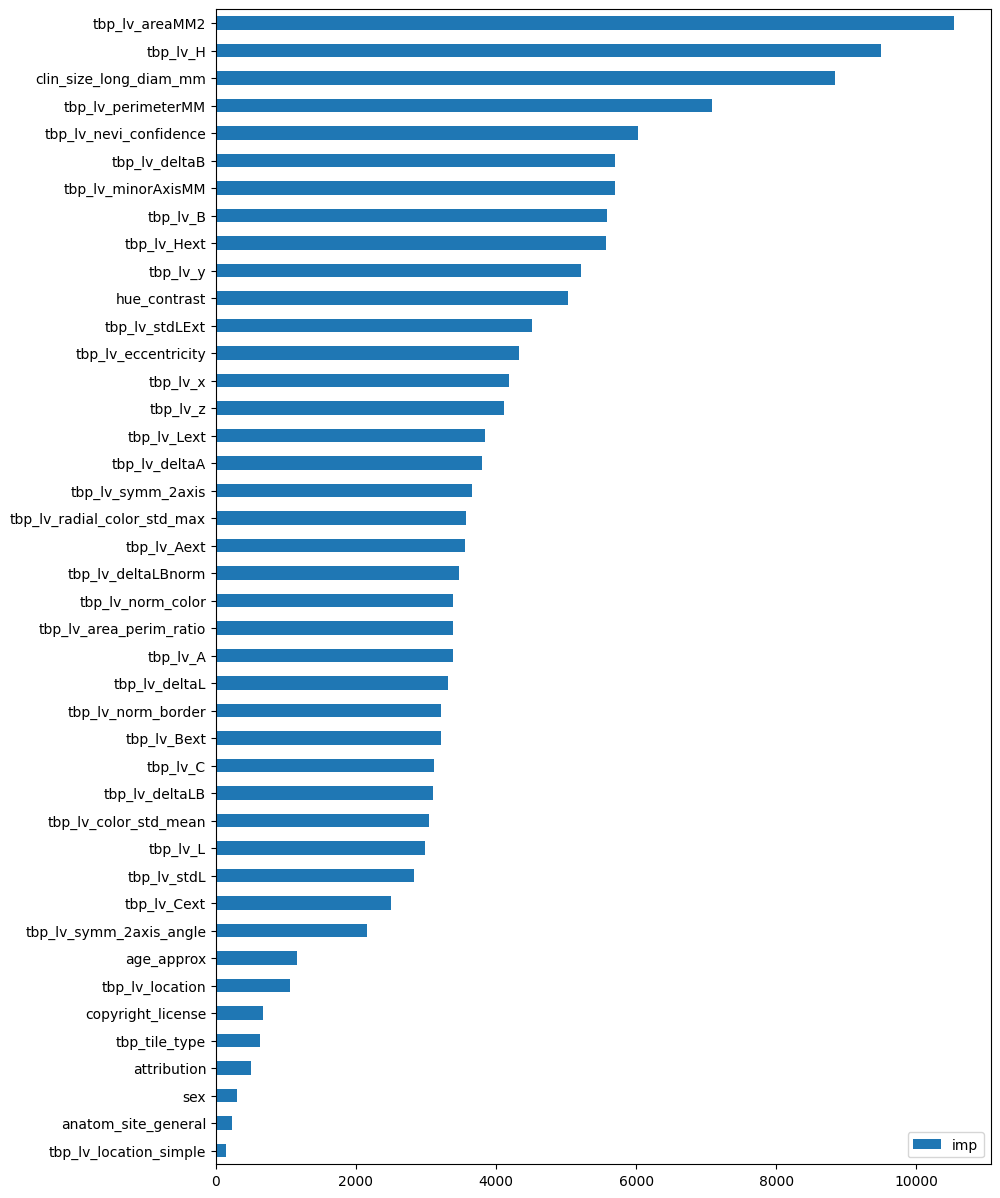

In [14]:
feature_importances = 0
for fold in all_folds:
    model = lgb.Booster(model_file=MODELS_OUTPUT_PATH / f"{cfg.model_name}_fold_{fold}.txt")
    if fold == 1:
        feature_names = model.feature_name()
    feature_importances += model.feature_importance(importance_type="gain")
feature_importances /= len(all_folds)

imp = pd.DataFrame.from_dict(dict(zip(feature_names, feature_importances)), 
                             orient="index", columns=["imp"]).sort_values("imp", ascending=True)
imp.plot(kind="barh", figsize=(10, 15))

metadata = {
    "params": params,
    "num_rounds": num_rounds,
    "es_rounds": es_rounds,
    "best_num_rounds": best_num_rounds,
    "val_auc_scores": val_auc_scores,
    "val_pauc_scores": val_pauc_scores,
    "cv_auc_oof": cv_auc_oof,
    "cv_pauc_oof": cv_pauc_oof,
    "cv_auc_avg": cv_auc_avg,
    "cv_pauc_avg": cv_pauc_avg
}

with open(f"{cfg.model_name}_run_metadata.json", "w") as f:
    json.dump(metadata, f)